# 【PaddleX助力疫情防护】基于PaddleX的行人社交安全距离检测

![](https://ai-studio-static-online.cdn.bcebos.com/312af8bf4662420395f0767b74fac4f7881a434ef24b45b79e198d8a94b659e8)

![](https://ai-studio-static-online.cdn.bcebos.com/adc19447834a4112865cc1e625e7e56451cd0db18879421694be1af6ea8f0140)


## 项目背景：

在当前危机中，减少传播的措施之一是隔离。尽管许多城市现在都在谨慎地重新开放，但是人们在外出时仍需要保持安全距离。

因此城市对人们的安全距离是否符合规则进行评估并采取相应的行动是很重要的。如果大多数人都遵守疫情期间的命令，那么就可以安全地开放更多的公共场合。

## 项目简介：

该项目使用PaddleX提供的YOLO3模型，在VOC数据集进行训练；

训练结果能够检测到监控画面的行人等不同类型车辆，mAP为0.6左右；

然后利用这些检测框框计算向量化表示的两两L2范数，用于进行社交距离较近的人的聚类。

## 一、安装PaddleX

In [1]:
!pip install paddlex -i https://mirror.baidu.com/pypi/simple

## 二、解压数据集

In [2]:
# !unzip /home/aistudio/data/data4379/pascalvoc.zip -d /home/aistudio/work/

## 三、设置工作路径

In [2]:
import matplotlib
matplotlib.use('Agg') 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import paddlex as pdx

os.chdir('/home/aistudio/work/')

## 四、生成数据集的TXT文件

PaddleX支持VOC格式数据，训练集和测试集需要定义txt文件，该文件保存图片路径和标注文件路径，格式如下：

JPEGImages/2009_003143.jpg Annotations/2009_003143.xml

JPEGImages/2012_001604.jpg Annotations/2012_001604.xml

In [3]:
base = '/home/aistudio/work/pascalvoc/VOCdevkit/VOC2012/'

imgs = os.listdir(os.path.join(base, 'JPEGImages'))
print('total:', len(imgs))

with open(os.path.join(base, 'train_list.txt'), 'w') as f:
    for im in imgs[:-200]:
        info = 'JPEGImages/'+im+' '
        info += 'Annotations/'+im[:-4]+'.xml\n'
        f.write(info)

with open(os.path.join(base, 'val_list.txt'), 'w') as f:
    for im in imgs[-200:]:
        info = 'JPEGImages/'+im+' '
        info += 'Annotations/'+im[:-4]+'.xml\n'
        f.write(info)

CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',

           'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',

           'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',

           'train', 'tvmonitor']

with open('labels.txt', 'w') as f:
    for v in CLASSES:
        f.write(v+'\n')

total: 17125


## 五、定义数据预处理模块
这里使用了图像混合、随机像素变换、随机膨胀、随即裁剪、随机水平翻转等数据增强方法。

In [4]:
from paddlex.det import transforms
train_transforms = transforms.Compose([
    transforms.MixupImage(mixup_epoch=250),
    transforms.RandomDistort(),
    transforms.RandomExpand(),
    transforms.RandomCrop(),
    transforms.Resize(target_size=512, interp='RANDOM'),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(),
])

eval_transforms = transforms.Compose([
    transforms.Resize(target_size=512, interp='CUBIC'),
    transforms.Normalize(),
])

## 六、定义训练集和测试集
这里取出后200张图片作为测试集

In [5]:
train_dataset = pdx.datasets.VOCDetection(
    data_dir=base,
    file_list=os.path.join(base, 'train_list.txt'),
    label_list='labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir=base,
    file_list=os.path.join(base, 'val_list.txt'),
    label_list='labels.txt',
    transforms=eval_transforms)

2020-07-20 22:13:24,797-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-07-20 22:13:25,134-INFO: generated new fontManager


2020-07-20 22:13:25 [INFO]	Starting to read file list from dataset...
2020-07-20 22:13:51 [INFO]	16925 samples in file /home/aistudio/work/pascalvoc/VOCdevkit/VOC2012/train_list.txt
creating index...
index created!
2020-07-20 22:13:52 [INFO]	Starting to read file list from dataset...
2020-07-20 22:13:52 [INFO]	200 samples in file /home/aistudio/work/pascalvoc/VOCdevkit/VOC2012/val_list.txt
creating index...
index created!


## 七、定义并训练模型
这里定义了一个YOLOv3，使用DarkNet53作为主干网络；

In [ ]:
num_classes = len(train_dataset.labels) + 1
print('class num:', num_classes)
model = pdx.det.YOLOv3(
    num_classes=num_classes, 
    backbone='DarkNet53'
)
model.train(
    num_epochs=20,
    train_dataset=train_dataset,
    train_batch_size=4,
    eval_dataset=eval_dataset,
    learning_rate=0.00025,
    lr_decay_epochs=[10, 15],
    save_interval_epochs=4,
    log_interval_steps=100,
    save_dir='./YOLOv3',
    pretrain_weights='IMAGENET',
    use_vdl=True)


## 八、评估模型

In [6]:
model = pdx.load_model('./YOLOv3/best_model')
model.evaluate(eval_dataset, batch_size=1, epoch_id=None, metric=None, return_details=False)

2020-07-20 22:15:01 [INFO]	Model[YOLOv3] loaded.
2020-07-20 22:15:01 [INFO]	Start to evaluating(total_samples=200, total_steps=200)...


100%|██████████| 200/200 [00:17<00:00, 11.76it/s]


OrderedDict([('bbox_map', 61.626957651198275)])

## 九、测试模型检测结果

infer time:0.118807s
detected num: 17


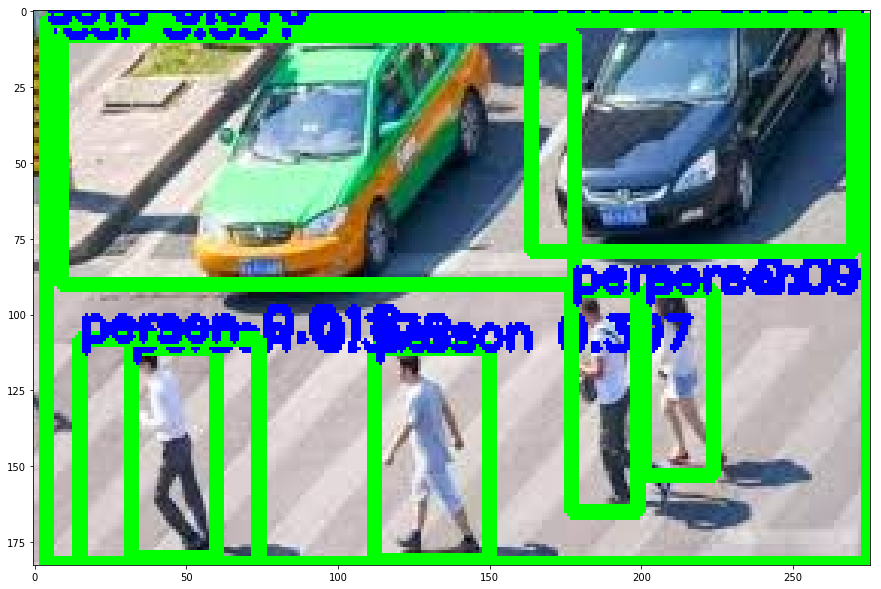

In [10]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

image_name = './test.jpg'
start = time.time()
result = model.predict(image_name, eval_transforms)
print('infer time:{:.6f}s'.format(time.time()-start))
print('detected num:', len(result))

im = cv2.imread(image_name)
font = cv2.FONT_HERSHEY_SIMPLEX
threshold = 0.0

for value in result:
    xmin, ymin, w, h = np.array(value['bbox']).astype(np.int)
    cls = value['category']
    score = value['score']
    if score < threshold:
        continue
    cv2.rectangle(im, (xmin, ymin), (xmin+w, ymin+h), (0, 255, 0), 4)
    cv2.putText(im, '{:s} {:.3f}'.format(cls, score),
                    (xmin, ymin), font, 0.5, (255, 0, 0), thickness=2)

cv2.imwrite('result.jpg', im)
plt.figure(figsize=(15,12))
plt.imshow(im[:, :, [2,1,0]])
plt.show()

## 十、导出量化模型
这里使用PaddleX提供的slim接口进行模型的后量化。

In [ ]:
pdx.slim.export_quant_model(model, eval_dataset, batch_size=2, batch_num=200, save_dir='./quant_model', cache_dir='./temp')

## 十一、定义行人射角距离检测器：

这里参考论文《Monitoring COVID-19 social distancing with person detection and tracking via fine-tuned YOLO v3 and Deepsort techniques》，使用聚类方法检测间距比较近的人群。

In [25]:
class PersonDistanceDetector(object):

    def __init__(self):

        self.model = model = pdx.load_model('./YOLOv3/best_model')

        self.boxes = []

        self.threshold = 0.3

        self.process_this_frame = False

    def feedCap(self, frame, right_direction='Rear', max_speed=120, task=0):

        self.process_this_frame = not self.process_this_frame

        retDict = {
            'frame': None,  # 检测结果可视化后的图片
            'list_of_cars': [],  # 裁剪出来的行人图片（追踪第一帧截取到的）
            'list_of_ids': [],  # 行人的ID
        }

        height, width, channels = frame.shape
        if self.process_this_frame:
            result = self.model.predict(frame)
            self.boxes = [v['bbox'] for v in result if v['score'] > self.threshold]

        circles = []
        for i in range(len(self.boxes)):
            x, y = int(self.boxes[i][0]), int(self.boxes[i][1])
            w, h = int(self.boxes[i][2]), int(self.boxes[i][3])
            cx, cy = x + w // 2, y + h
            frame = cv2.line(
                frame, (cx, cy), (cx, cy - h // 2), (0, 255, 0), 2)
            frame = cv2.circle(frame, (cx, cy - h // 2), 5, (255, 20, 200), -1)
            circles.append([cx, cy - h // 2, h])

        int_circles_list = []
        indexes = []
        for i in range(len(circles)):
            x1, y1, r1 = circles[i]
            for j in range(i + 1, len(circles)):
                x2, y2, r2 = circles[j]
                if int_circle(x1, y1, x2, y2, r1 // 2, r2 // 2) >= 0 and abs(y1 - y2) < r1 // 4:
                    indexes.append(i)
                    indexes.append(j)

                    int_circles_list.append([x1, y1, r1])
                    int_circles_list.append([x2, y2, r2])
                    cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)

                    circle_img = frame * 0
            rows, cols, _ = frame.shape

            for i in range(len(circles)):
                x, y, r = circles[i]

                if i in indexes:
                    color = (0, 0, 255)
                else:
                    color = (0, 200, 20)
                scale = (r) / 100
                transparentOverlay1(
                    frame, dst_circle, (x, y - 5), alphaVal=110, color=color, scale=scale)

            cv2.rectangle(frame, (0, rows - 80), (cols, rows), (0, 0, 0), -1)
            cv2.putText(frame,
                        "Total Persons : " + str(len(self.boxes)),
                        (20, rows - 40),
                        fontFace=cv2.QT_FONT_NORMAL,
                        fontScale=1,
                        color=(215, 220, 245))

        retDict['frame'] = frame

        return retDict

def int_circle(x1, y1, x2, y2, r1, r2):
    distSq = (x1 - x2) * (x1 - x2) + (y1 - y2) * (y1 - y2)
    radSumSq = (r1 + r2) * (r1 + r2)
    if distSq == radSumSq:
        return 1
    elif distSq > radSumSq:
        return -1
    else:
        return 0


def get_bounding_box(outs, height, width):

    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            if class_id != 0:
                continue  # 0 is ID of persons
            confidence = scores[class_id]
            if confidence > 0.3:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    return boxes, confidences, class_ids


def transparentOverlay1(src, overlay, pos=(0, 0), scale=1, color=(0, 200, 100), alphaVal=255):

    overlay = cv2.resize(overlay.copy(), (0, 0), fx=scale, fy=scale)
    h, w, _ = overlay.shape  # Size of foreground

    rows, cols, _ = src.shape  # Size of background Image
    x, y = pos[0], pos[1]  # Position of foreground/overlay image
    x -= w // 2

    background = src[y:min(y + h, rows), x:min(x + w, cols)]
    b_h, b_w, _ = background.shape
    if b_h <= 0 or b_w <= 0:
        return src
    foreground = overlay[0:b_h, 0:b_w]
    alpha = foreground[:, :, 1].astype(float)
    alpha[alpha > 235] = alphaVal
    alpha = cv2.merge([alpha, alpha, alpha])
    alpha = alpha / 255.0

    foreground = foreground.astype(float)
    background = background.astype(float)

    foreground = np.zeros_like(foreground) + color

    foreground = cv2.multiply(alpha, foreground[:, :, :3])
    background = cv2.multiply(1.0 - alpha, background)
    outImage = cv2.add(foreground, background).astype("uint8")

    src[y:y + b_h, x:x + b_w] = outImage
    return src


M3 = np.array([
    [0.8092, -0.2960, 11],
    [0.0131, 0.0910, 30],
    [0.0001, -0.0052, 1.0]
])

circle_img = np.zeros((100, 100, 3))
cv2.circle(circle_img, (50, 50), 40, (0, 240, 0), 4)
dst_circle = cv2.warpPerspective(circle_img, M3, (100, 100))


## 十二、测试并保存检测视频：

In [13]:
!pip install imutils

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25850 sha256=3b998c0c60a0574128786ca35813d946e7df9163b8449a34a7f6a3a40245a6e1
  Stored in directory: /home/aistudio/.cache/pip/wheels/b0/2e/d2/0771cdc54b4c4f319b7ea5b09731992402961488e7a09f6a7a
Successfully built imutils


In [28]:
import imutils
import cv2
from tqdm import tqdm

if __name__ == '__main__':

    name = 'demo'
    path = 'p.mp4'

    det = PersonDistanceDetector()
    cap = cv2.VideoCapture(path)
    fps = int(cap.get(5))
    print('fps:', fps)
    t = int(1000/fps)
    frames_num = int(cap.get(7))

    size = None
    car = None
    print('processing...')

    for _ in tqdm(range(frames_num)):

        # try:
            _, im = cap.read()
            if im is None:
                break

            result = det.feedCap(im)
            result = result['frame']
            result = imutils.resize(result, height=500)
            if size is None:
                size = (result.shape[1], result.shape[0])
                fourcc = cv2.VideoWriter_fourcc(
                    'm', 'p', '4', 'v')  # opencv3.0
                videoWriter = cv2.VideoWriter(
                    'result.mp4', fourcc, fps, size)
            videoWriter.write(result)
            cv2.waitKey(1)

        # except Exception as e:
        #     print(e)
        #     break

    cap.release()
    videoWriter.release()
    cv2.destroyAllWindows()
    print('done')


2020-07-20 22:24:24 [INFO]	Model[YOLOv3] loaded.
fps: 23
processing...


100%|██████████| 583/583 [00:39<00:00, 14.62it/s]


done


# 总结：

### 在本项目中我们完成了以下任务：

1. 使用PaddleX在VOC数据集训练了YOLOv3模型；

2. 使用训练好的YOLOv3模型进行行人的检测；

3. 使用聚类算法将检测到的行人聚类；

### 结论：

PaddleX提供的模型训练和部署接口非常实用，帮助提高开发者的开发效率；

## 关于作者：
> 北京理工大学 大二在读

> 感兴趣的方向为：目标检测、人脸识别、EEG识别等

> 将会定期分享一些小项目，感兴趣的朋友可以互相关注一下：[主页链接](http://aistudio.baidu.com/aistudio/personalcenter/thirdview/67156)

> 也欢迎大家fork、评论交流

> 作者博客主页：[https://blog.csdn.net/weixin_44936889](https://blog.csdn.net/weixin_44936889)